In [133]:
import sys
sys.path.append("../")


In [134]:
%pip install ftfy regex tqdm

Note: you may need to restart the kernel to use updated packages.


In [135]:
import torch

REPO_DIR = "dino/dinov3"

backbone_weights = f"dino/weights/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth"
weights = f"dino/weights/dinov3_vitl16_dinotxt_vision_head_and_text_encoder-a442d8f5.pth"

model, tokenizer = dino_backbone, tokenizer = torch.hub.load(REPO_DIR, 'dinov3_vitl16_dinotxt_tet1280d20h24l', source='local', weights=weights, backbone_weights=backbone_weights)

# Load sample image

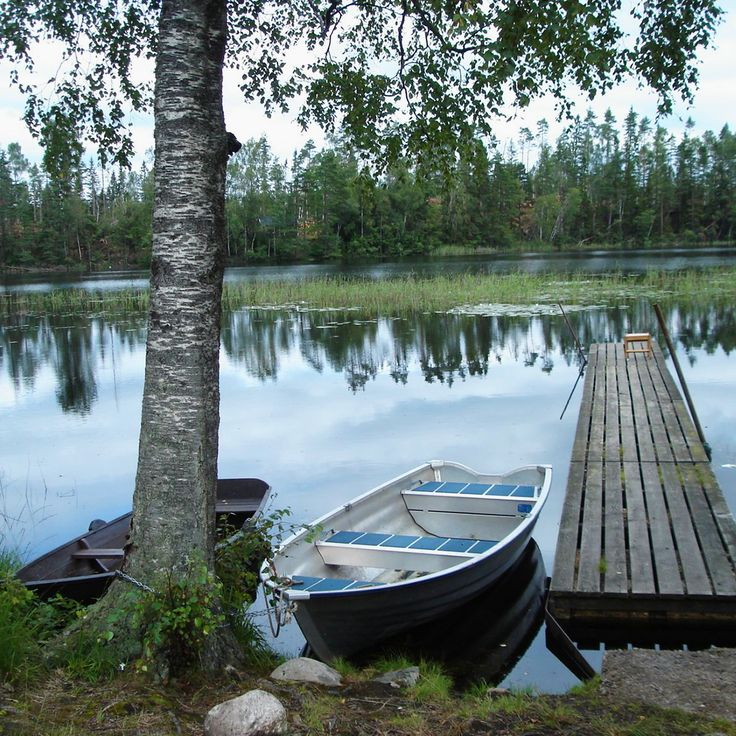

In [260]:
import urllib
from PIL import Image

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")
    
img_size = 736

# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
EXAMPLE_IMAGE_URL = "https://i.pinimg.com/736x/44/8f/fd/448ffd7762c9251c4865e7f56fa161aa.jpg"
img_pil = load_image_from_url(EXAMPLE_IMAGE_URL)
img_pil = img_pil.resize((img_size, img_size), Image.BICUBIC)
display(img_pil)

# Get Zero-shot classification scores on sample image

In [261]:
openai_imagenet_templates = (
    lambda c: f"a bad photo of a {c}.",
    lambda c: f"a photo of many {c}.",
    lambda c: f"a sculpture of a {c}.",
    lambda c: f"a photo of the hard to see {c}.",
    lambda c: f"a low resolution photo of the {c}.",
    lambda c: f"a rendering of a {c}.",
    lambda c: f"graffiti of a {c}.",
    lambda c: f"a bad photo of the {c}.",
    lambda c: f"a cropped photo of the {c}.",
    lambda c: f"a tattoo of a {c}.",
    lambda c: f"the embroidered {c}.",
    lambda c: f"a photo of a hard to see {c}.",
    lambda c: f"a bright photo of a {c}.",
    lambda c: f"a photo of a clean {c}.",
    lambda c: f"a photo of a dirty {c}.",
    lambda c: f"a dark photo of the {c}.",
    lambda c: f"a drawing of a {c}.",
    lambda c: f"a photo of my {c}.",
    lambda c: f"the plastic {c}.",
    lambda c: f"a photo of the cool {c}.",
    lambda c: f"a close-up photo of a {c}.",
    lambda c: f"a black and white photo of the {c}.",
    lambda c: f"a painting of the {c}.",
    lambda c: f"a painting of a {c}.",
    lambda c: f"a pixelated photo of the {c}.",
    lambda c: f"a sculpture of the {c}.",
    lambda c: f"a bright photo of the {c}.",
    lambda c: f"a cropped photo of a {c}.",
    lambda c: f"a plastic {c}.",
    lambda c: f"a photo of the dirty {c}.",
    lambda c: f"a jpeg corrupted photo of a {c}.",
    lambda c: f"a blurry photo of the {c}.",
    lambda c: f"a photo of the {c}.",
    lambda c: f"a good photo of the {c}.",
    lambda c: f"a rendering of the {c}.",
    lambda c: f"a {c} in a video game.",
    lambda c: f"a photo of one {c}.",
    lambda c: f"a doodle of a {c}.",
    lambda c: f"a close-up photo of the {c}.",
    lambda c: f"a photo of a {c}.",
    lambda c: f"the origami {c}.",
    lambda c: f"the {c} in a video game.",
    lambda c: f"a sketch of a {c}.",
    lambda c: f"a doodle of the {c}.",
    lambda c: f"a origami {c}.",
    lambda c: f"a low resolution photo of a {c}.",
    lambda c: f"the toy {c}.",
    lambda c: f"a rendition of the {c}.",
    lambda c: f"a photo of the clean {c}.",
    lambda c: f"a photo of a large {c}.",
    lambda c: f"a rendition of a {c}.",
    lambda c: f"a photo of a nice {c}.",
    lambda c: f"a photo of a weird {c}.",
    lambda c: f"a blurry photo of a {c}.",
    lambda c: f"a cartoon {c}.",
    lambda c: f"art of a {c}.",
    lambda c: f"a sketch of the {c}.",
    lambda c: f"a embroidered {c}.",
    lambda c: f"a pixelated photo of a {c}.",
    lambda c: f"itap of the {c}.",
    lambda c: f"a jpeg corrupted photo of the {c}.",
    lambda c: f"a good photo of a {c}.",
    lambda c: f"a plushie {c}.",
    lambda c: f"a photo of the nice {c}.",
    lambda c: f"a photo of the small {c}.",
    lambda c: f"a photo of the weird {c}.",
    lambda c: f"the cartoon {c}.",
    lambda c: f"art of the {c}.",
    lambda c: f"a drawing of the {c}.",
    lambda c: f"a photo of the large {c}.",
    lambda c: f"a black and white photo of a {c}.",
    lambda c: f"the plushie {c}.",
    lambda c: f"a dark photo of a {c}.",
    lambda c: f"itap of a {c}.",
    lambda c: f"graffiti of the {c}.",
    lambda c: f"a toy {c}.",
    lambda c: f"itap of my {c}.",
    lambda c: f"a photo of a cool {c}.",
    lambda c: f"a photo of a small {c}.",
    lambda c: f"a tattoo of the {c}.",
)

In [307]:
import torch
from dinov3.data.transforms import make_classification_eval_transform

image_preprocess = make_classification_eval_transform(resize_size=img_size, crop_size=img_size)
image_tensor = torch.stack([image_preprocess(img_pil)], dim=0).cuda()


# texts = ["photo of dogs", "photo of a chair", "photo of a bowl", "photo of a tupperware"]
# class_names = ["dog", "chair", "bowl", "tupperware"]

class_names = ["house", "teapot", "sky", "boat", "forest", "tree", "fire", "river", "ground", "pier"]
texts = [template(name) for name in class_names for template in openai_imagenet_templates ]


tokenized_texts_tensor = tokenizer.tokenize(texts).cuda()
model = model.cuda()
with torch.autocast('cuda', dtype=torch.float):
    with torch.no_grad():
        image_features = model.encode_image(image_tensor)
        text_features = model.encode_text(tokenized_texts_tensor)
        
text_features = text_features.reshape(len(class_names), len(openai_imagenet_templates), -1)
text_features = text_features.mean(dim=1)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (
    text_features.cpu().float().numpy() @ image_features.cpu().float().numpy().T
)
print(similarity) 

[[0.07415704]
 [0.02663442]
 [0.08111378]
 [0.1310794 ]
 [0.10814515]
 [0.08762512]
 [0.04772396]
 [0.11128668]
 [0.09174608]
 [0.11589663]]


# Get patch embeddings

In [308]:
with torch.autocast('cuda', dtype=torch.float):
    with torch.no_grad():
        image_class_tokens, image_patch_tokens, backbone_patch_tokens = model.encode_image_with_patch_tokens(image_tensor)
        text_features_aligned_to_patch = model.encode_text(tokenized_texts_tensor)[:, 1024:] # Part of text features that is aligned to patch features

In [309]:
text_features_aligned_to_patch = text_features_aligned_to_patch.reshape(len(class_names), len(openai_imagenet_templates), -1)
text_features_aligned_to_patch = text_features_aligned_to_patch.mean(dim=1)

In [310]:
text_features_aligned_to_patch.shape

torch.Size([10, 1024])

In [340]:
import torch.nn.functional as F

B, P, D = image_patch_tokens.shape
H = W = int(P**0.5) 
x = image_patch_tokens.movedim(2, 1).unflatten(2, (H, W)).float()  # [B, D, H, W]
x = F.interpolate(x, size=(img_size, img_size), mode="nearest") #, align_corners=False)
x = F.normalize(x, p=2, dim=1)
y = F.normalize(text_features_aligned_to_patch.float(), p=2, dim=1)
per_patch_similarity_to_text = torch.einsum("bdhw,cd->bchw", x, y)
pred_idx = per_patch_similarity_to_text.argmax(1).squeeze(0)

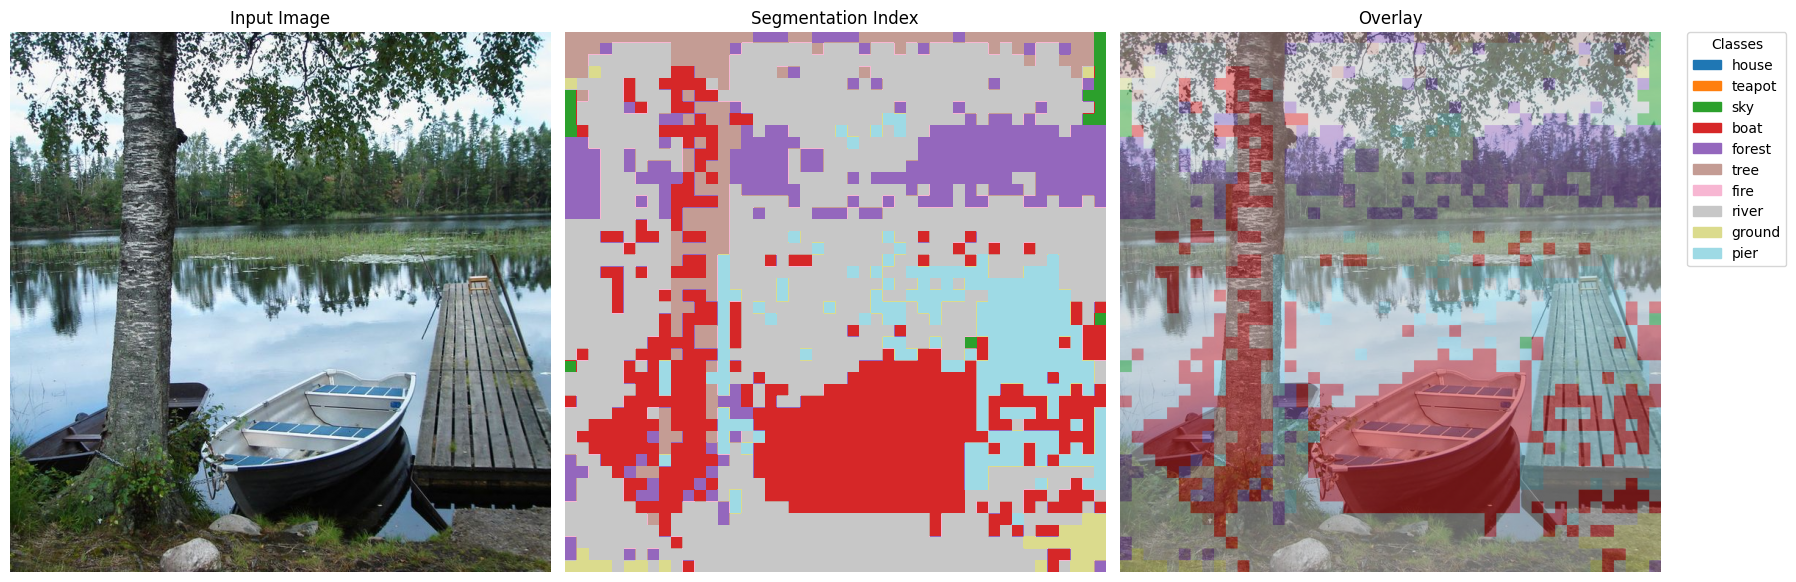

In [341]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# pred_idx: [H, W] segmentation indices
seg_map = pred_idx.cpu().numpy()

# Create a colormap
num_classes = len(class_names)
cmap = plt.get_cmap("tab20", num_classes)
colored_seg = cmap(seg_map / num_classes)[..., :3]  # RGB only

# Convert image_tensor (PIL → np.array already done)
img = np.array(img_pil) / 255.0

# Overlay segmentation
alpha = 0.5
overlay = (1 - alpha) * img + alpha * colored_seg

# Plot
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(seg_map, cmap=cmap, vmin=0, vmax=num_classes-1)
plt.title("Segmentation Index")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

# Create legend
handles = [
    mpatches.Patch(color=cmap(i / num_classes), label=cls) 
    for i, cls in enumerate(class_names)
]
plt.legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.,
    title="Classes"
)

plt.tight_layout()
plt.show()
